# Network topologies and mobility in the ns-3 simulator

Let's start by importing the ns-3 bindings.

In [1]:
from ns import ns

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Now let's define a function that plots the network node positions.

In [2]:
from matplotlib import pyplot as plt

# Get the coordinates for each node in the NodeContainer and plot
def plotNodePosition(nodeContainer : ns.NodeContainer, showLegend: bool = True) -> None:
    for node_i in range(nodeContainer.GetN()):
        node = nodeContainer.Get(node_i).__deref__()
        mobility = node.GetObject[ns.MobilityModel]().__deref__()
        position = mobility.GetPosition()
        plt.scatter((position.x), (position.y), label=f"Node {node.GetId()}")
    plt.ylabel("Y (m)")
    plt.xlabel("X (m)")
    if showLegend:
        plt.legend()
    plt.show()

Now we can create and visualize a few static topologies.

Let's try a very simple topology with 10 nodes divided in two lines.

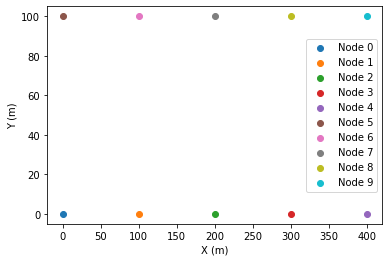

In [3]:
def plotNodesInLineTopology():
    ns.Simulator.Destroy()
    
    # Create a topology with two rows with 5 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    linePositions = ns.CreateObject("ListPositionAllocator")
    for line in range(2):
        for column in range(5):
            linePositions.__deref__().Add (ns.Vector(100*column, 100*line, 0))

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::ConstantPositionMobilityModel")
    mobilityHelper.SetPositionAllocator (linePositions)
    mobilityHelper.Install (nodes)

    plotNodePosition(nodes)

plotNodesInLineTopology()

Now let's try something more complicated. We can pass the coordinates for each individual node, to setup whatever topology we want. In this case, we are going to allocate the 10 nodes into a circle with radius of 100 meters.

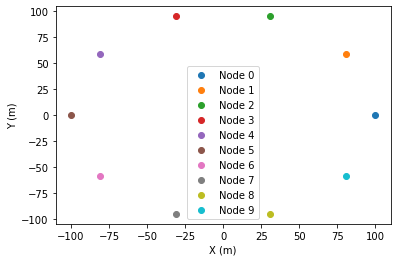

In [4]:
def plotNodesInCircleTopology():
    import math
    ns.Simulator.Destroy()
    
    # Create a circular topology
    nodes = ns.NodeContainer()
    nodes.Create(10)

    linePositions = ns.CreateObject("ListPositionAllocator")
    radius = 100
    degPerNode = 2*math.pi / nodes.GetN()
    for node_i in range(nodes.GetN()):
        linePositions.__deref__().Add (ns.Vector(radius*math.cos(degPerNode*node_i),
                                                 radius*math.sin(degPerNode*node_i),
                                                 0))

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::ConstantPositionMobilityModel")
    mobilityHelper.SetPositionAllocator (linePositions)
    mobilityHelper.Install (nodes)

    plotNodePosition(nodes)

plotNodesInCircleTopology()

There are some topologies that are very common, and have their specific helpers. 

Since these helpers also install network links between the nodes, we can adapt out plotting to show the links and their respective channels.

In [5]:
def plotNodePositionAndChannels(nodeContainer : ns.NodeContainer, showLegend: bool = True) -> None:
    nodeIdToCoordinate = {}
    channelIdToNodeIds = {}
    for node_i in range(nodeContainer.GetN()):
        node = nodeContainer.Get(node_i).__deref__()
        nodeId = node.GetId()
        mobility = node.GetObject[ns.MobilityModel]().__deref__()
        position = mobility.GetPosition()
        nodeIdToCoordinate[nodeId] = (position.x, position.y)
        for device_i in range(node.GetNDevices()):
            netdevice = node.GetDevice(device_i).__deref__()
            if hasattr(netdevice, "GetChannel"):
                channel = netdevice.GetChannel().__deref__()
                channelId = channel.GetId()
                if channelId not in channelIdToNodeIds:
                    channelIdToNodeIds[channelId] = []
                channelIdToNodeIds[channelId].append(nodeId)
        plt.scatter((position.x), (position.y), label=f"Node {node.GetId()}")

    for (channelId, channelNodes) in channelIdToNodeIds.items():
        for i in range(len(channelNodes)):
            for j in range(i, len(channelNodes)):
                node_i = nodeIdToCoordinate[channelNodes[i]]
                node_j = nodeIdToCoordinate[channelNodes[j]]
                plt.plot([node_i[0], node_j[0]], [node_i[1], node_j[1]], label=f"Channel {channelId}")

    plt.ylabel("Y (m)")
    plt.xlabel("X (m)")
    if showLegend:
        plt.legend()
    plt.show()

Ok, we should now be able to see the actual links between the nodes.

The point-to-point network interface, for example, has a star topology helper, that allocates nodes around a central hub in the center, and connects each of the nodes to the hub with a point-to-point link.

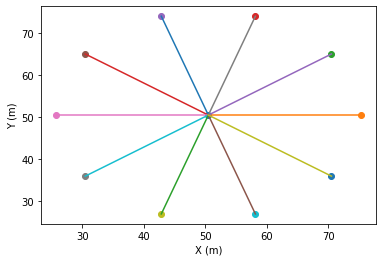

In [6]:
def plotNodesInStarTopology():
    ns.Simulator.Destroy()
    
    # Create point-to-point star topology with 20 nodes
    pointToPoint = ns.PointToPointHelper()
    star = ns.PointToPointStarHelper(10, pointToPoint)
    star.BoundingBox(1, 1, 100, 100);

    # Get node container to plot the topology
    nodes = ns.NodeContainer()
    nodes.Add(star.GetHub())
    for node_i in range(star.SpokeCount()):
        nodes.Add(star.GetSpokeNode(node_i))

    plotNodePositionAndChannels(nodes, showLegend=False)
    
plotNodesInStarTopology()

Another example of such helpers is the grid topology helper, also for point-to-point.

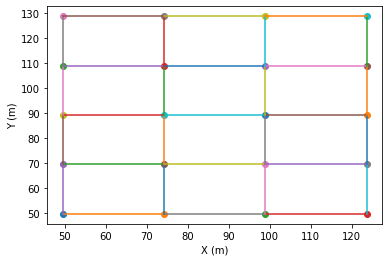

In [7]:
def plotNodesInGridTopology():
    ns.Simulator.Destroy()
    
    # Create point-to-point grid topology with 20 nodes
    pointToPoint = ns.PointToPointHelper()
    grid = ns.PointToPointGridHelper(5,4, pointToPoint)
    grid.BoundingBox(1, 1, 100, 100);

    # Get node container to plot the topology
    nodes = ns.NodeContainer()
    for node_i in range(5):
        for node_j in range(4):
            nodes.Add(grid.GetNode(node_i, node_j))

    plotNodePositionAndChannels(nodes, showLegend=False)
    
plotNodesInGridTopology()

All of these topologies were static.
For some scenarios, this might be OK.
For mobile networks in urban scenarios, that isn't very realistic.
We can add some mobility to increase the realism.

To plot the moving nodes, we need a new function.

In [8]:
coordinatesHistoric = []

# Create an event in C++ for the following python function
ns.cppyy.cppdef("""
   #ifndef pymakeevent
   #define pymakeevent
   namespace ns3
   {
       EventImpl* pythonMakeEvent(void (*f)(NodeContainer&), NodeContainer& nodes)
       {
           return MakeEvent(f, nodes);
       }
   }
   #endif
""")

def getNodeCoordinates(nodeContainer : ns.NodeContainer) -> None:
    global coordinatesHistoric

    coordinates = {}
    for node_i in range(nodeContainer.GetN()):
        node = nodeContainer.Get(node_i).__deref__()
        mobility = node.GetObject[ns.MobilityModel]().__deref__()
        position = mobility.GetPosition()
        coordinates[f"Node {node.GetId()}"] = ((position.x), (position.y))
    coordinatesHistoric.append((ns.Simulator.Now().GetSeconds(), coordinates))

    # Re-schedule after every 1 second
    event = ns.pythonMakeEvent(getNodeCoordinates, nodeContainer)
    ns.Simulator.Schedule(ns.Seconds(1), event)
    
def animateSimulation():
    global coordinatesHistoric
    
    # Save a copy and clean historic for the next animation
    coordinatesHistoricCopy = coordinatesHistoric
    coordinatesHistoric = []
    
    # Animate coordinates from the simulation
    from matplotlib import pyplot as plt
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    
    fig = plt.figure()
    plots = {}
    def init():
        # Initialize animation artists
        for (node, coordinate) in coordinatesHistoricCopy[0][1].items():
            plots[node] = plt.scatter(*coordinate, label=node)

        # Determine animation bounds
        x_bounds = [999999,0]
        y_bounds = [999999,0]
        for i in range(len(coordinatesHistoricCopy)):
            for (node, coordinate) in coordinatesHistoricCopy[i][1].items():
                if (coordinate[0] < x_bounds[0]):
                    x_bounds[0] = coordinate[0]
                if (coordinate[0] > x_bounds[1]):
                    x_bounds[1] = coordinate[0]
                if (coordinate[1] < y_bounds[0]):
                    y_bounds[0] = coordinate[1]
                if (coordinate[1] > y_bounds[1]):
                    y_bounds[1] = coordinate[1]
                    
        # Add a margin to the bounds
        x_bounds[0] -= 1
        y_bounds[0] -= 1
        x_bounds[1] += 1
        y_bounds[1] += 1
        
        # Set animation bounds
        plt.xlim(x_bounds)
        plt.ylim(y_bounds)

    def animate(i):
        for (node, coordinate) in coordinatesHistoricCopy[i][1].items():
            plots[node].set_offsets(coordinate)
    
    # Animate the historic of coordinates
    anim = FuncAnimation(fig, animate, init_func=init,
                         frames = len(coordinatesHistoricCopy),
                         interval = 100, repeat=True)
    
    # Display the interactive animation
    display(HTML(anim.to_jshtml()))
    
    # Prevent plotting the final frame as a static image
    plt.close()
    return

This was quite more complicated than I've imagined, but works well enough.

Let's try to see if really works.

In [9]:
# Test the animation
coordinatesHistoric = [(0.0, {"Node 1": ((0.0), (0.0))}),
                       (1.0, {"Node 1": ((10.0), (0.0))}),
                       (2.0, {"Node 1": ((10.0), (10.0))}),
                       (3.0, {"Node 1": ((0.0), (10.0))}),
                       ]
animateSimulation()

Now that we have seen it working, let's try it with a real simulation.

This case is the same with two rows we saw at the beginning, but now the nodes go towards the opposite row, crossing in the center.

In [10]:
def animateConstantVelocityNodesInLineTopology():
    ns.Simulator.Destroy()

    # Create a topology with two rows with 5 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    linePositions = ns.CreateObject("ListPositionAllocator")
    for line in range(2):
        for column in range(5):
            linePositions.__deref__().Add (ns.Vector(100*column, 100*line, 0))

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::ConstantVelocityMobilityModel")
    mobilityHelper.SetPositionAllocator (linePositions)
    mobilityHelper.Install (nodes)
    
    # Set node velocities
    for line in range(2):
        for column in range(5):
            node = nodes.Get(line*5+column).__deref__()
            mobility = node.GetObject[ns.MobilityModel]().__deref__()
            mobility.SetVelocity(ns.Vector(0, 1 if line == 0 else -1, 0));
    

    # Schedule getNodeCoordinates to run after 1 second of simulation
    event = ns.pythonMakeEvent(getNodeCoordinates, nodes)
    ns.Simulator.Schedule(ns.Seconds(1), event)

    # Run simulation for 100 virtual seconds
    ns.Simulator.Stop(ns.Seconds(100))
    ns.Simulator.Run()
    
    animateSimulation()

animateConstantVelocityNodesInLineTopology()

We can also use use the random walk mobility model.

In [11]:
def animateRandomWalkNodes():
    ns.Simulator.Destroy()

    # Create a topology with 10 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    # Some allocators allows us to specify a few parameters,
    # that are used along random variables to determine the position for each node
    randomBoxPositions = ns.CreateObject("RandomBoxPositionAllocator")
    randomBoxPositions.SetAttribute("X", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Y", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Z", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=1.0]"));

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::RandomWalk2dMobilityModel")
    mobilityHelper.SetPositionAllocator (randomBoxPositions)
    mobilityHelper.Install (nodes)  

    # Schedule getNodeCoordinates to run after 1 second of simulation
    event = ns.pythonMakeEvent(getNodeCoordinates, nodes)
    ns.Simulator.Schedule(ns.Seconds(1), event)

    # Run simulation for 100 virtual seconds
    ns.Simulator.Stop(ns.Seconds(100))
    ns.Simulator.Run()
    
    animateSimulation()

animateRandomWalkNodes()

If none of the available mobility models are a good fit for your use-case, you can implement your own. For example, using the waypoint mobility model.

In [12]:
def animateWaypointWalkNodes():
    ns.Simulator.Destroy()

    import math

    # Create a topology with 10 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    # Some allocators allows us to specify a few parameters,
    # that are used along random variables to determine the position for each node
    randomBoxPositions = ns.CreateObject("RandomBoxPositionAllocator")
    randomBoxPositions.SetAttribute("X", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Y", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Z", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=1.0]"));

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::WaypointMobilityModel")
    mobilityHelper.SetPositionAllocator (randomBoxPositions)
    mobilityHelper.Install (nodes)

    # We need to setup the waypoints each node will walk on
    # In this case, we are going to make them walk in
    # the DVD Logo fashion
    for node_i in range(nodes.GetN()):
        node = nodes.Get(node_i).__deref__()
        mobility = node.GetObject[ns.WaypointMobilityModel]().__deref__()
        currPos = mobility.GetPosition()
        time = ns.Seconds(0.5)
        DIR = [1,1]
        while time.GetSeconds() < 100:
            dirChanged = False
            nextPos = ns.Vector(currPos.x+(2 if DIR[0] else -2),
                                currPos.y+(2 if DIR[1] else -2),
                                0
                                )
            if DIR[0] == 0:
                if nextPos.x < 0:
                    DIR[0] = 1
                    dirChanged = True
            else:
                if nextPos.x > 100:
                    DIR[0] = 0
                    dirChanged = True

            if DIR[1] == 0:
                if nextPos.y < 0:
                    DIR[1] = 1
                    dirChanged = True
            else:
                if nextPos.y > 100:
                    DIR[1] = 0
                    dirChanged = True

            # Skip next position since it goes out of bounds
            if dirChanged:
                continue
            time = ns.Seconds(1+time.GetSeconds())
            wpt = ns.Waypoint (time, nextPos);
            mobility.AddWaypoint(wpt)
            currPos = nextPos


    # Schedule getNodeCoordinates to run after 1 second of simulation
    event = ns.pythonMakeEvent(getNodeCoordinates, nodes)
    ns.Simulator.Schedule(ns.Seconds(1), event)

    # Run simulation for 100 virtual seconds
    ns.Simulator.Stop(ns.Seconds(100))
    ns.Simulator.Run()

    animateSimulation()

animateWaypointWalkNodes()

## How mobility affects wireless networks?

The mobility is one of the many complicated tasks wireless communications have to handle.

Getting further away from a base station/access point increases the distance the radio signal has to travel, which causes it to get attenuated. 

Next, we will build a test scenario for demonstration to show that fact.

FlowID: 1 (TCP 192.168.1.2/49153 --> 192.168.1.1/9)
  Lost Packets:  0
  Tx Packets: 1207
  Rx Packets: 1207
FlowID: 2 (TCP 192.168.1.3/49153 --> 192.168.1.1/9)
  Lost Packets:  0
  Tx Packets: 1207
  Rx Packets: 1207
FlowID: 3 (TCP 192.168.1.4/49153 --> 192.168.1.1/9)
  Lost Packets:  0
  Tx Packets: 1207
  Rx Packets: 1207


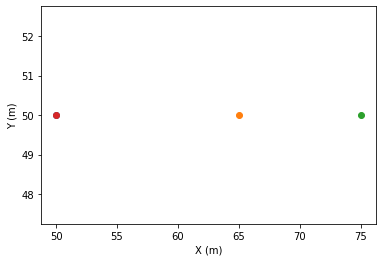

[0.0, 0.0, 0.0]

In [13]:
# Variable to keep track of wifi mode changes
wifiMode_history_per_staid = {}

def wireless_mobility_demonstration(mcs=0, plot_topology=False, print_results=False, mobility=False):
    ns.Simulator.Destroy()

    # ns.GlobalValue.Bind("SimulatorImplementationType", ns.StringValue("ns3::VisualSimulatorImpl"))

    # Createt a single access point at the middle of our space
    aps = ns.NodeContainer()
    aps.Create(1)

    # Create a topology with 10 stations/user devices
    stas = ns.NodeContainer()
    stas.Create(3)

    mobilityHelper = ns.MobilityHelper()

    # Set mobility of the access point
    centralPosition = ns.CreateObject("ListPositionAllocator")
    centralPosition.__deref__().Add(ns.Vector(50, 50, 0))
    mobilityHelper.SetMobilityModel("ns3::ConstantPositionMobilityModel")
    mobilityHelper.SetPositionAllocator(centralPosition)
    mobilityHelper.Install(aps)

    # Set mobility of user devices
    uePositions = ns.CreateObject("ListPositionAllocator")
    uePositions.__deref__().Add(ns.Vector(50, 50, 0))
    uePositions.__deref__().Add(ns.Vector(65, 50, 0))
    uePositions.__deref__().Add(ns.Vector(75, 50, 0))
    if not mobility:
        mobilityHelper.SetMobilityModel("ns3::ConstantPositionMobilityModel")
    else:
        mobilityHelper.SetMobilityModel("ns3::ConstantVelocityMobilityModel")
    mobilityHelper.SetPositionAllocator(uePositions)
    mobilityHelper.Install(stas)
    if mobility: 
        for sta in range(stas.GetN()):
            stas.Get(sta).GetObject[ns.MobilityModel]().__deref__().SetVelocity(ns.Vector3D(2,0,0))

    # Configure wifi channel
    spectrumChannel = ns.CreateObject("MultiModelSpectrumChannel")
    lossModel = ns.CreateObject("LogDistancePropagationLossModel")
    spectrumChannel.__deref__().AddPropagationLossModel(lossModel)

    # Configure the wifi stack
    wifiHelper = ns.WifiHelper()
    wifiHelper.SetStandard(ns.WIFI_STANDARD_80211ax)  # using WiFi 6

    # For static scenarios, use a fixed mcs
    if not mobility:
        wifiHelper.SetRemoteStationManager("ns3::ConstantRateWifiManager",
                                           "DataMode", ns.StringValue(f"HeMcs{mcs}"),
                                           "ControlMode", ns.StringValue(f"OfdmRate{int(ns.HePhy.GetNonHtReferenceRate(mcs)/1e6)}Mbps")
                                           )

    wifiPhyHelper = ns.SpectrumWifiPhyHelper()
    wifiPhyHelper.Set("ChannelSettings",
                      ns.StringValue("{50, 160, BAND_5GHZ, 0}")
                      )  # 160MHz-wide band in the 5GHz range
    wifiPhyHelper.SetChannel(spectrumChannel)

    # Create a new wifi ssid and connect the AP and STAs to it
    wifiSsid = ns.Ssid("ns3-80211ax")
    wifiMacHelper = ns.WifiMacHelper()
    wifiMacHelper.SetType("ns3::StaWifiMac", "Ssid", ns.SsidValue(wifiSsid))
    stasDevices = wifiHelper.Install(wifiPhyHelper, wifiMacHelper, stas)
    
    if mobility:
        # Generate a callback version per sta since the trace StaId field is wonky when using OFDMA
        def GetPeriodicWifiPhyModeTrace(staId):
            def PeriodicWifiPhyModeTrace(packet: ns.Packet,
                                        channelFreq: int,
                                        txVector: ns.WifiTxVector,
                                        ampdu: ns.MpduInfo,
                                        signalNoiseDbm: ns.SignalNoiseDbm,
                                        _: int) -> None:
                global wifiMode_history_per_staid
                mode = txVector.GetMode()  # Can't get a MCS value below ns.WIFI_MOD_CLASS_HT
                if print_results:
                    print(f"At {ns.Simulator.Now().GetSeconds()} station {staId} transmitted with {mode}")
                if staId not in wifiMode_history_per_staid:
                    wifiMode_history_per_staid[staId] = [[], []]
                wifiMode_history_per_staid[staId][0].append(ns.Simulator.Now().GetSeconds())
                wifiMode_history_per_staid[staId][1].append(str(mode))
            return PeriodicWifiPhyModeTrace

        # Create the callback via C++
        ns.cppyy.cppdef("""
                #ifndef periodictrace
                #define periodictrace
                namespace ns3
                {
                    const Callback<void, Ptr<const Packet>, uint16_t, WifiTxVector, MpduInfo, SignalNoiseDbm, uint16_t>
                    make_PeriodicWifiPhyModeTrace(
                        void(*func)(Ptr<const Packet>, uint16_t, WifiTxVector, MpduInfo, SignalNoiseDbm, uint16_t)
                        )
                    {
                        return MakeCallback(func);
                    }
                }
                #endif
            """)

        callbacks = []  # Store callables to prevent deletion
        # Register the callback function above, that will allow us to track wifi mode changes
        for i in range(stasDevices.GetN()):
            wifiNetDevice = stasDevices.Get(i).__deref__().GetObject["WifiNetDevice"]()
            for wifiPhy in wifiNetDevice.GetPhys():
                callbacks.append(GetPeriodicWifiPhyModeTrace(i))  # Store callable to prevent deletion
                wifiPhy.__deref__().TraceConnectWithoutContext("MonitorSnifferRx", ns.make_PeriodicWifiPhyModeTrace(callbacks[i]))

    # Install the AP interface
    wifiMacHelper.SetType("ns3::ApWifiMac", "Ssid", ns.SsidValue(wifiSsid))
    apsDevices = wifiHelper.Install(wifiPhyHelper, wifiMacHelper, aps)

    # Setup IP stack and addresses
    stack = ns.InternetStackHelper()
    stack.Install(aps)
    stack.Install(stas)

    address = ns.Ipv4AddressHelper()
    address.SetBase("192.168.1.0", "255.255.255.0")
    apsNodeInterfaces = address.Assign(apsDevices)
    staNodeInterfaces = address.Assign(stasDevices)

    # Schedule getNodeCoordinates to run after 1 second of simulation
    allNodes = ns.NodeContainer()
    allNodes.Add(stas)
    allNodes.Add(aps)

    # Setup applications
    port = 9
    localAddress = ns.InetSocketAddress(ns.Ipv4Address.GetAny(), port).ConvertTo()
    server = ns.PacketSinkHelper("ns3::TcpSocketFactory", localAddress)
    serverApp = server.Install(aps)
    serverApp.Start(ns.Seconds(0))
    serverApp.Stop(ns.Seconds(9))

    for i in range(stas.GetN()):
        client = ns.OnOffHelper("ns3::TcpSocketFactory", staNodeInterfaces.GetAddress(i).ConvertTo())
        client.SetAttribute("OnTime",
                            ns.StringValue("ns3::ConstantRandomVariable[Constant=1]"))
        client.SetAttribute("OffTime",
                            ns.StringValue("ns3::ConstantRandomVariable[Constant=1]"))
        client.SetAttribute("PacketSize", ns.UintegerValue(1400))
        client.SetAttribute("DataRate", ns.DataRateValue(1500000))
        remoteAddress = ns.InetSocketAddress(apsNodeInterfaces.GetAddress(0), port).ConvertTo()
        client.SetAttribute("Remote", ns.AddressValue(remoteAddress))

        clientApp = client.Install(stas.Get(i))
        clientApp.Start(ns.Seconds(1))
        clientApp.Stop(ns.Seconds(8))

    # Collect flow statistics
    flowHelper = ns.FlowMonitorHelper()
    flowMonitor = flowHelper.InstallAll()

    ns.Ipv4GlobalRoutingHelper.PopulateRoutingTables()

    if mobility:
        # Schedule getNodeCoordinates to run after 1 second of simulation
        event = ns.pythonMakeEvent(getNodeCoordinates, allNodes)
        ns.Simulator.Schedule(ns.Seconds(1), event)

    # Run simulation for 10 virtual seconds
    ns.Simulator.Stop(ns.Seconds(10))
    ns.Simulator.Run()


    flowMonitor.CheckForLostPackets()
    classifier = flowHelper.GetClassifier()
    
    lost_packets = []
    for flow_id, flow_stats in flowMonitor.GetFlowStats():
        t = classifier.FindFlow(flow_id)
        if flow_id >= 4:
            break
        proto = {6: 'TCP', 17: 'UDP'}[t.protocol]
        if print_results:
            print("FlowID: %i (%s %s/%s --> %s/%i)" % \
                  (flow_id, proto, t.sourceAddress, t.sourcePort, t.destinationAddress, t.destinationPort))
            print("  Lost Packets: ", flow_stats.txPackets-flow_stats.rxPackets)
            print("  Tx Packets:", flow_stats.txPackets)
            print("  Rx Packets:", flow_stats.rxPackets)
        lost_packets.append((flow_stats.txPackets-flow_stats.rxPackets)*100/flow_stats.txPackets)

    if plot_topology:
        plotNodePosition(allNodes, showLegend=False)
        
    return lost_packets
        
wireless_mobility_demonstration(plot_topology=True, print_results=True, mcs=0)

To ensure the signal gets properly decoded by the received, the devices can:
1. increase their output power, which is regulated by governmental agencies and drain the device batteries;
2. use more resilient modulation and coding schemes, which are less affected by attenuation and interference;
3. use fancy beamforming techniques to focus the transmitted power into a smaller beam that has a longer range.
    
As we can see in the results above, there were no lost packets from the STAs (bottom left, bottom right, top right) to the AP (top left). We were using the MCS=0, which corresponds to BPSK (Binary Phase Key Shifting, with 1 bits per symbol), at a coding rate of 1/2. A complete MCS table can be found [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vQXoEYLGWrR1aGyGaTXOOaDQSPLfeC4rv70KRFuRP6eZ5fL-Ku_YI6DgS6zZMNyIhQpQmnKQ1O7abij/pubhtml?gid=1367372895&single=true).

Let's try each different MCS and plot the lost packets for each of them.

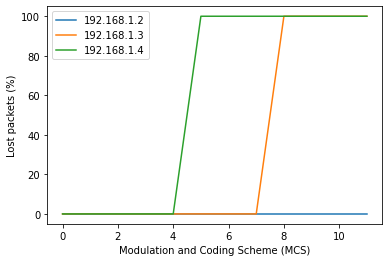

In [14]:
lost_packets_per_STA = [[], [], []]
for mcs in range(12):
    lost_packets = wireless_mobility_demonstration(mcs=mcs)
    for i in range(3):
        lost_packets_per_STA[i].append(lost_packets[i])
        
for i in range(3):
    plt.plot(list(range(12)), lost_packets_per_STA[i], label=f"192.168.1.{i+2}")
plt.ylabel("Lost packets (%)")
plt.xlabel("Modulation and Coding Scheme (MCS)")
plt.legend()
plt.show()

As it can be seen, different STAs at different distances from the AP have different upper limits to their modulation and coding schemes. 

The STA farther away from the AP, IP `192.168.1.4`, can use up to MCS 4 before losing its connection. That station was placed 20 meters away from the AP.

The second STA is 15 meters away from the AP, IP `192.168.1.3`, and can use up to MCS 7 before losing its connection.

The closest STA to the AP, IP `192.168.1.2`, is 10 meters away from it. It can use up to MCS 9 before losing its connection.

### Adding some mobility to the wifi example

The previous example, however, was limited to static topologies. We can add some mobility to check how the MCS behaves over time when the stations move.

In [15]:
wireless_mobility_demonstration(mobility=True)

[0.0, 25.922509225092252, 100.0]

Now we can see our stations (STAs) moving around.

In [16]:
animateSimulation()

As you can imagine, their MCS should now fluctuate, as part of Wi-Fi's link adaptation procedures.

Let'se see if it actually changes over time.

Sorted by prefixes: ['OfdmRate6Mbps', 'OfdmRate12Mbps', 'OfdmRate24Mbps', 'HeMcs0', 'HeMcs2', 'HeMcs3', 'HeMcs4', 'HeMcs5', 'HeMcs6', 'HeMcs7', 'HeMcs8', 'HeMcs9', 'HeMcs10', 'HeMcs11']


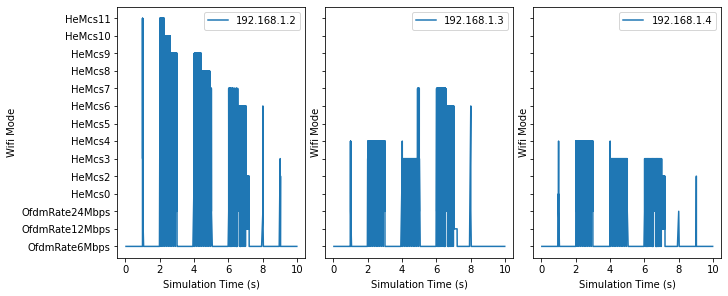

In [17]:
all_modes = set()
for staId in wifiMode_history_per_staid:
    all_modes.update(wifiMode_history_per_staid[staId][1])
all_modes = list(all_modes)

# Use a radix sort trick to get entries in the expected order
import re
#print("Original:", all_modes)
# sort by numbers
all_modes = list(sorted(all_modes, key=lambda x: int(re.findall('\d+', x)[0])))
#print("Sorted by numbers:", all_modes)
# sort by prefixes
all_modes = list(sorted(all_modes, key=lambda x: "He" in x))
print("Sorted by prefixes:", all_modes)

fig = plt.figure(layout='constrained', figsize=(10, 4))
axis = fig.subplots(1,3,sharey=True) # 1 row, 3 columns, shared y axis for correct ytick scale

# Convert wifi mode labels into numeric indexes
for staId in wifiMode_history_per_staid:
    axis[staId].plot(wifiMode_history_per_staid[staId][0], 
             list(map(lambda x: all_modes.index(x), wifiMode_history_per_staid[staId][1])), 
             label=f"192.168.1.{staId+2}",
            )

    axis[staId].set_yticks(ticks=list(range(len(all_modes))), labels=all_modes)
    axis[staId].set_ylabel("Wifi Mode")
    axis[staId].set_xlabel("Simulation Time (s)")
    axis[staId].legend()
plt.show()

Each station wifi mode history is shown above. As we can see, the wifi mode do change over time, as the station moves closer or further away from the access point.  

Some of these changes is due to control data being sent at the lowest possible rate (e.g. OfdmRate6Mbps), which is why you should disable old standards on your access point. Yes, backwards compatibility and a bit of extra range will be exchanged for much faster throughput.

Other increases/decreases during the data transmission (thick columns) are due to mobility alone.